## Description:

        Investigate OTU classification in controls and mock community for the ERA MiSeq run



In [29]:
Controls = "/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/controls.rds"

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: iterators

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:gridExtra’:

    combine


  warnings.w

In [7]:
%%R -i Controls
phy = readRDS(Controls)
phy = prune_taxa(taxa_sums(phy) > 3, phy)
phy 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 143 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 143 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 143 tips and 142 internal nodes ]


### apply gsub across columns replacing __ w/ "" reload tax_table to phyloseq object

In [8]:
%%R
t = tax_table(phy)
t = apply(t, 2, function(y) gsub("__", "", y))
tax_table(phy) = t

## Controls 

In [11]:
%%R
Mock = subset_samples(phy, X.sampleID == "MockComm")
Mock = prune_taxa(taxa_sums(Mock) > 3, Mock)

# NegControl = subset_samples(phy, X.sample %in% "NegControl-1")
# Pos = prune_taxa(taxa_sums(Pos) > 0, Pos)
# tax_table(Pos)
Mock_n = unique(tax_table(Mock)) %>% dim %>% .[1]
Mock_n
(Mock_n)
paste("OTUs recovered in MockCommunity: ", as.character(Mock_n), sep = "" )


[1] "OTUs recovered in MockCommunity: 45"


# Comparing mock community OTU composition to table of 'true' mock community composition

In [81]:
%%R 
mock.known = read.delim('/home/bryan/ERA/data/Hay-lab_mock_community.txt', header = TRUE, sep = '\t')
mock.known$Phylum %>% unique()

# Remove Eukaryotes and archaea as in pipeline
mock.known = filter(mock.known, !Phylum %in% c("Fungi", "Euryarchaeota"))
Mlength = dim(mock.known)[1]
mock.known = mock.known %>%
    group_by(Phylum) %>%
    summarize(freq.known.norm = length(Phylum) / Mlength)

mock.known %>% print(n = 20)

# A tibble: 8 × 2
           Phylum freq.known.norm
           <fctr>           <dbl>
1                      0.03846154
2   Acidobacteria      0.03846154
3  Actinobacteria      0.15384615
4   Bacteroidetes      0.11538462
5   Cyanobacteria      0.03846154
6      Firmicutes      0.23076923
7  Proteobacteria      0.34615385
8 Verrucomicrobia      0.03846154


## Comparing relative compositions of phylum

In [140]:
%%R

Mock.snorm = transform_sample_counts(Mock, function(x) x/sum(x))


tbl.otu = psmelt(Mock.snorm) %>%
        select(OTU, Abundance, Rank2, Rank5)

tbl.otu %>% head()

       OTU  Abundance           Rank2               Rank5
46 OTU.143 0.07415439 Verrucomicrobia Verrucomicrobiaceae
75 OTU.539 0.06395857  Proteobacteria    Burkholderiaceae
65 OTU.282 0.06280412   Bacteroidetes   Flavobacteriaceae
71 OTU.440 0.06037654      Firmicutes         Bacillaceae
67 OTU.295 0.05957814  Actinobacteria        Arthrobacter
73 OTU.484 0.05499272  Proteobacteria  Enterobacteriaceae


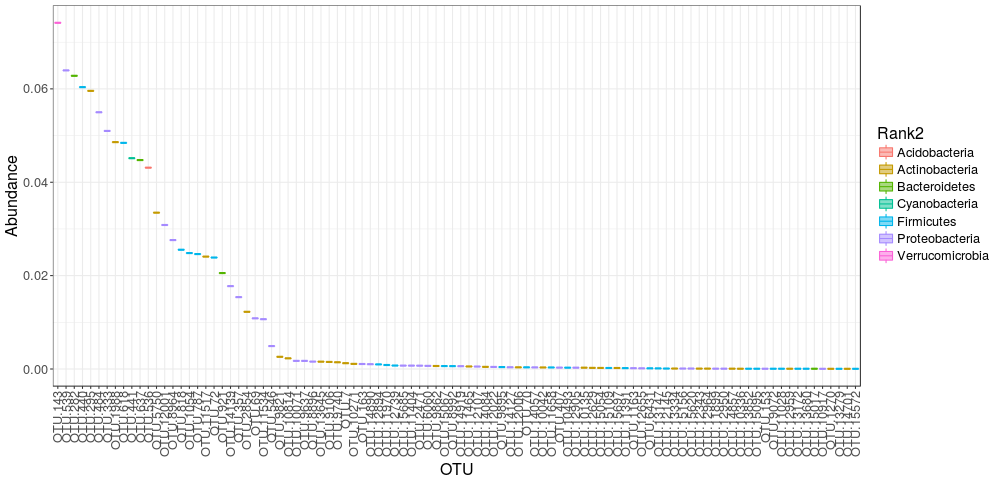

In [84]:
%%R -w 1000 
tbl.otu = tbl.otu %>%
    arrange(desc(Abundance)) %>%   # rearrange the df in the order we want (1,2,3,4,5)
    mutate(OTU = factor(OTU, OTU)) # relevel OTU in order

ggplot(tbl.otu, aes(OTU, Abundance, color=Rank2, fill=Rank2)) +
    geom_boxplot(alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

27 OTUs at higher abundance, additional 18 OTUs at low abundance

In [85]:
%%R 
# mock communities from sequence data

mock.est = tbl.otu %>% 
    group_by(Rank2) %>%
    summarize(n=n(),
              freq.est.norm = sum(Abundance))

head(mock.est)


# A tibble: 6 × 3
           Rank2     n freq.est.norm
          <fctr> <int>         <dbl>
1  Acidobacteria     1    0.04312456
2 Actinobacteria    29    0.19362356
3  Bacteroidetes     4    0.12816529
4  Cyanobacteria     1    0.04515294
5     Firmicutes    28    0.21414468
6 Proteobacteria    34    0.30163457


In [86]:
%%R
mock.known %>% head
mock.j = full_join(mock.est, mock.known, c('Rank2' = 'Phylum')) %>%
    gather('variable', 'value', freq.est.norm, freq.known.norm) 
mock.j

# A tibble: 16 × 4
             Rank2     n        variable      value
             <chr> <int>           <chr>      <dbl>
1    Acidobacteria     1   freq.est.norm 0.04312456
2   Actinobacteria    29   freq.est.norm 0.19362356
3    Bacteroidetes     4   freq.est.norm 0.12816529
4    Cyanobacteria     1   freq.est.norm 0.04515294
5       Firmicutes    28   freq.est.norm 0.21414468
6   Proteobacteria    34   freq.est.norm 0.30163457
7  Verrucomicrobia     1   freq.est.norm 0.07415439
8                     NA   freq.est.norm         NA
9    Acidobacteria     1 freq.known.norm 0.03846154
10  Actinobacteria    29 freq.known.norm 0.15384615
11   Bacteroidetes     4 freq.known.norm 0.11538462
12   Cyanobacteria     1 freq.known.norm 0.03846154
13      Firmicutes    28 freq.known.norm 0.23076923
14  Proteobacteria    34 freq.known.norm 0.34615385
15 Verrucomicrobia     1 freq.known.norm 0.03846154
16                    NA freq.known.norm 0.03846154


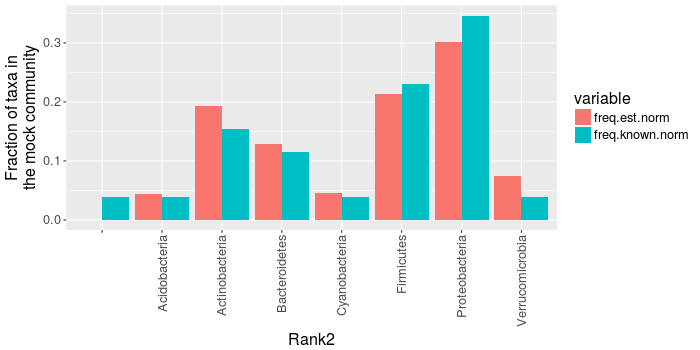

In [87]:
%%R -w 700 -h 350

ggplot(mock.j, aes(Rank2, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

### Filtering out low abundance taxa

In [139]:
%%R
# of OTUs
tbl.otu %>% filter(Abundance > 0.001) %>% dim()

[1] 39  4


In [88]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    filter(abundance > 0.001) %>%
    mutate(Rank2 = gsub('^__', '', Rank2)) %>%
    group_by(otu, Rank2) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    select(Rank2) 

mock.est = tmp$Rank2 %>% table %>% as.data.frame
colnames(mock.est) = c('phylum', 'freq.est')

mock.est = mock.est %>%
    group_by() %>%
    mutate(freq.est.norm = freq.est / sum(freq.est))

mock.est 

# A tibble: 7 × 3
           phylum freq.est freq.est.norm
           <fctr>    <int>         <dbl>
1   Acidobacteria        1    0.02564103
2  Actinobacteria       12    0.30769231
3   Bacteroidetes        3    0.07692308
4   Cyanobacteria        1    0.02564103
5      Firmicutes        6    0.15384615
6  Proteobacteria       15    0.38461538
7 Verrucomicrobia        1    0.02564103


## Comparing relative compositions of 

In [107]:
%%R 

mock.known = read.delim('/home/bryan/ERA/data/Hay-lab_mock_community.txt', header = TRUE, sep = '\t')
mock.known = mock.known %>% filter(Phylum != "" & Genus != "Candida") #removing archaea and fungi from mock comm

# mock.known = mock.known$genus %>% table %>% as.data.frame
# colnames(mock.known) = c('genus', 'freq.known')
SumKnown = length(mock.known$Genus) 
mock.summary = mock.known %>%
     group_by(Family) %>%
     summarize (freq.known.norm = length(Family) / SumKnown)

mock.summary %>% print(n = 27)

# A tibble: 19 × 2
                Family freq.known.norm
                <fctr>           <dbl>
1    Acidobacteriaceae            0.04
2       Alcaligenaceae            0.08
3          Bacillaceae            0.08
4      Burkholderiales            0.04
5   Enterobacteriaceae            0.08
6      Enterococcaceae            0.04
7    Flavobacteriaceae            0.08
8    Helicobacteraceae            0.04
9     Lactobacillaceae            0.04
10      Micrococcaceae            0.12
11     Nocardioidaceae            0.04
12      Planococcaceae            0.04
13    Pseudomonadaceae            0.04
14        Rhizobiaceae            0.04
15 Sphingobacteriaceae            0.04
16   Sphingomonadaceae            0.04
17   Staphylococcaceae            0.04
18    Synechococcaceae            0.04
19 Verrucomicrobiaceae            0.04


In [108]:
%%R
head(tbl.j)

Source: local data frame [6 x 12]
Groups: otu [6]

        otu   sample    abundance  total_abund    Rank1          Rank2
     <fctr>    <chr>        <dbl>        <dbl>   <fctr>         <fctr>
1 OTU.11899 MockComm 7.552463e-05 7.552463e-05 Bacteria Proteobacteria
2 OTU.14139 MockComm 1.774829e-02 1.774829e-02 Bacteria Proteobacteria
3 OTU.15685 MockComm 7.336678e-04 7.336678e-04 Bacteria Proteobacteria
4 OTU.12107 MockComm 5.286724e-04 5.286724e-04 Bacteria Proteobacteria
5    OTU.69 MockComm 1.085397e-02 1.085397e-02 Bacteria Proteobacteria
6 OTU.14127 MockComm 3.776231e-04 3.776231e-04 Bacteria Proteobacteria
# ... with 6 more variables: Rank3 <fctr>, Rank4 <fctr>, Rank5 <fctr>,
#   Rank6 <fctr>, Rank7 <fctr>, Rank8 <fctr>


In [119]:
%%R 
# mock communities from sequence data

tmp = tbl.j %>% 
    mutate(Rank6 = gsub('uncultured_', '', Rank6)) %>%
    group_by(Rank2, Rank4, Rank5) %>%
    summarize(RelAbund = sum(abundance)) 
 
head(tmp)

# mock.est = tmp$Rank6 %>% table %>% as.data.frame
# colnames(mock.est) = c('genus', 'freq.est')

# mock.est = mock.est %>%
#     group_by() %>%
#     mutate(freq.est.norm = freq.est / sum(freq.est))

# mock.est %>% head

Source: local data frame [6 x 4]
Groups: Rank2, Rank4 [4]

           Rank2             Rank4             Rank5     RelAbund
          <fctr>            <fctr>            <fctr>        <dbl>
1  Acidobacteria Acidobacteriaceae    Acidobacterium 4.312456e-02
2 Actinobacteria Microbacteriaceae    Microbacterium 4.315693e-05
3 Actinobacteria    Micrococcaceae      Arthrobacter 1.194800e-01
4 Actinobacteria    Micrococcaceae           Kocuria 2.836489e-02
5 Actinobacteria    Micrococcaceae       Micrococcus 4.573556e-02
6  Bacteroidetes  Flavobacteriales Flavobacteriaceae 8.335761e-02


In [131]:
%%R

mock.j = tmp %>% 
    mutate(Family = ifelse(Rank2 %in% c("Acidobacteria", "Actinobacteria", "Cyanobacteria"), as.character(Rank4), as.character(Rank5))) %>%

    full_join(., mock.summary, by = c('Family' = 'Family')) %>%
    arrange(Family) %>%
    
     gather('variable', 'value', RelAbund, freq.known.norm) %>%
    group_by(variable)

 mock.j %>% print(n = 51)

Source: local data frame [52 x 6]
Groups: variable [2]

             Rank2              Rank4               Rank5              Family
            <fctr>             <fctr>              <fctr>               <chr>
1    Acidobacteria  Acidobacteriaceae      Acidobacterium   Acidobacteriaceae
2               NA                 NA                  NA      Alcaligenaceae
3       Firmicutes         Bacillales         Bacillaceae         Bacillaceae
4   Proteobacteria    Burkholderiales    Burkholderiaceae    Burkholderiaceae
5               NA                 NA                  NA     Burkholderiales
6   Proteobacteria  Enterobacteriales  Enterobacteriaceae  Enterobacteriaceae
7       Firmicutes    Lactobacillales     Enterococcaceae     Enterococcaceae
8    Cyanobacteria            FamilyI       Synechococcus             FamilyI
9    Bacteroidetes   Flavobacteriales   Flavobacteriaceae   Flavobacteriaceae
10  Proteobacteria  Campylobacterales   Helicobacteraceae   Helicobacteraceae
11      

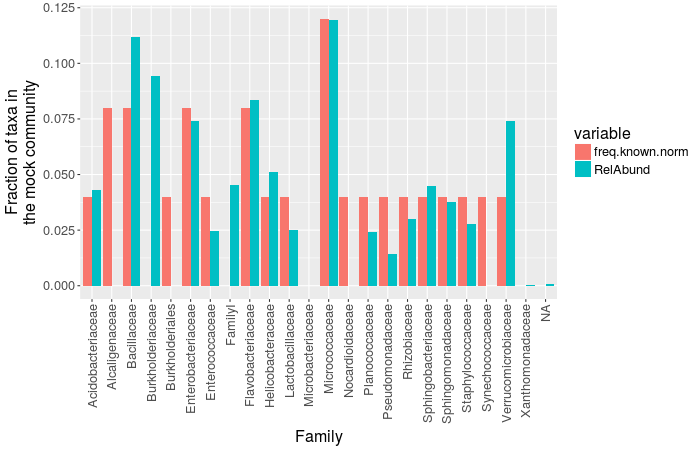

In [133]:
%%R -w 700 -h 450

ggplot(mock.j, aes(Family, value, fill=variable)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Fraction of taxa in\nthe mock community') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

### Conclusions

* The number of OTUs in the sequenced mock is pretty similar to the actual number of taxa in the community
  * 45 estimated compared to 27 actual
  * Estimation is better is low abundance taxa are filtered
* The community composition between sequenced and true communities is:
  * Similar at the phylum level
  * Good at the family level, but some mismatch in annotation

## Identify taxa in negative controls

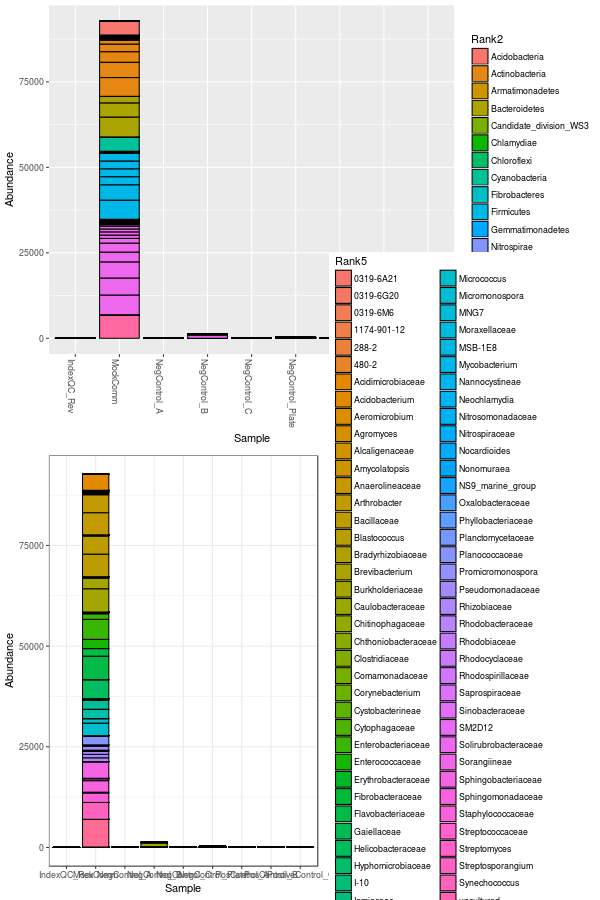

In [39]:
%%R -w 600 -h 900

p1 = plot_bar(phy, fill = 'Rank2', x = "Sample")

p2 = plot_bar(phy, fill = 'Rank5', x = "Sample") +
        theme_bw() +
        theme(plot.title = element_text(face="bold", size=20)) +
        guides(fill=guide_legend(ncol=2))

grid.arrange(p1, p2, ncol=1)

## Save OTUs in negative controls

In [57]:
%%R
phy %>% sample_data %>%
    select(X.sampleID)

Sample Data:        [4 samples by 1 sample variables]:
                     X.sampleID
MockCommunity-1 MockCommunity-1
NegControl-1       NegControl-1
NegControl-2       NegControl-2
PosControl-1       PosControl-1


In [40]:
%%R
NegControl = subset_samples(phy, X.sampleID %in% c("NegControl_A","NegControl_B", "NegControl_C",
                                                    "NegControl_Plate"))

NegControl = prune_taxa(taxa_sums(NegControl) > 0, NegControl)
NegControl


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 163 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 163 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 163 tips and 162 internal nodes ]


In [41]:
%%R
FalsePositives = filter_taxa(NegControl, function(x) sum(x > 0) > 0, TRUE) %>% taxa_names()
     

In [42]:
%%R
FalsePositives = filter_taxa(NegControl, function(x) sum(x > 0) > 0, TRUE) %>% taxa_names()

#Positives = filter_taxa(NegControl, function(x) sum(x > 0) < 1, TRUE) %>% taxa_names()

controls.FP = prune_taxa(FalsePositives, phy)  

controls.FP


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 163 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 163 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 163 tips and 162 internal nodes ]


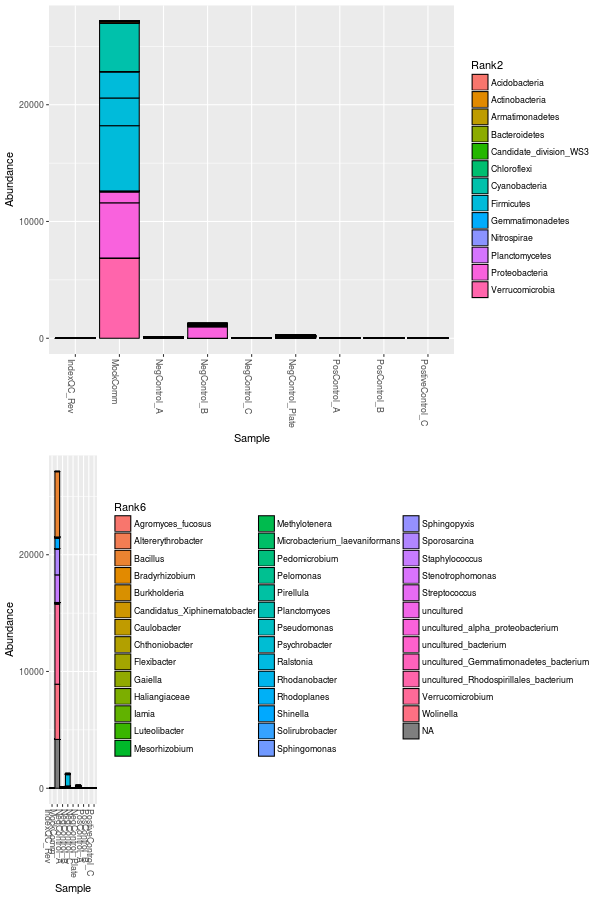

In [43]:
%%R -w 600 -h 900
# false positive composition in controls

p1 = plot_bar(controls.FP, fill = 'Rank2', x = "Sample")

p2 = plot_bar(controls.FP, fill = 'Rank6', x = "Sample")

grid.arrange(p1, p2, ncol=1)

In [63]:
%%R
tmp = controls.FP %>% subset_samples(X.sampleID == "MockComm")
tmp = prune_taxa(taxa_sums(tmp)>0, tmp)
tmp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 15 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 15 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 15 tips and 14 internal nodes ]


In [65]:
%%R
mdf = psmelt(tmp)
mdf$relAbundance = mdf$Abundance / 92710

In [68]:
%%R
mdf %>% select(OTU, relAbundance, Rank2, Rank3, Rank4, Rank5, Rank6)

        OTU relAbundance           Rank2                 Rank3
4   OTU.143 7.413440e-02 Verrucomicrobia      Verrucomicrobiae
7   OTU.440 6.029555e-02      Firmicutes               Bacilli
6   OTU.333 5.097616e-02  Proteobacteria Epsilonproteobacteria
8   OTU.442 4.514076e-02   Cyanobacteria           SubsectionI
14  OTU.818 2.553123e-02      Firmicutes               Bacilli
13   OTU.72 2.410743e-02      Firmicutes               Bacilli
10   OTU.69 9.998921e-03  Proteobacteria   Alphaproteobacteria
11    OTU.7 1.164923e-03  Actinobacteria         Micrococcales
5   OTU.163 7.981879e-04  Proteobacteria   Gammaproteobacteria
12   OTU.70 3.559487e-04      Firmicutes               Bacilli
2  OTU.1163 1.725812e-04  Proteobacteria   Gammaproteobacteria
3  OTU.1272 4.314529e-05  Actinobacteria         Micrococcales
1    OTU.11 1.078632e-05  Proteobacteria    Betaproteobacteria
9   OTU.678 1.078632e-05  Proteobacteria    Betaproteobacteria
15   OTU.99 1.078632e-05  Actinobacteria     Corynebact

# Check abundance of false positives in overall dataset

In [44]:
%%R
ERA = readRDS('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_snorm.rds')


    
#Filter to false positives
ERA.FP = prune_taxa(FalsePositives, ERA) 
ERA.FP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 145 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 145 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 145 tips and 144 internal nodes ]


In [48]:
%%R
sample_data(ERA.FP)$Planted = ifelse(sample_data(ERA.FP)$Genotype == "Bare", "Bare", "Rhizosphere")

In [49]:
%%R

mdf = ERA.FP %>% psmelt()

In [50]:
%%R
MeanFP = mdf %>% 
    filter(TimePoint != "T0") %>%
    group_by(OTU, Planted) %>%
    summarise(MeanAbund = mean(Abundance)) %>%
    arrange(desc(MeanAbund)) 

Taxa = tax_table(phy) %>% as.data.frame
Taxa$OTU = row.names(Taxa)

MeanFP = left_join(MeanFP, Taxa, by = "OTU")

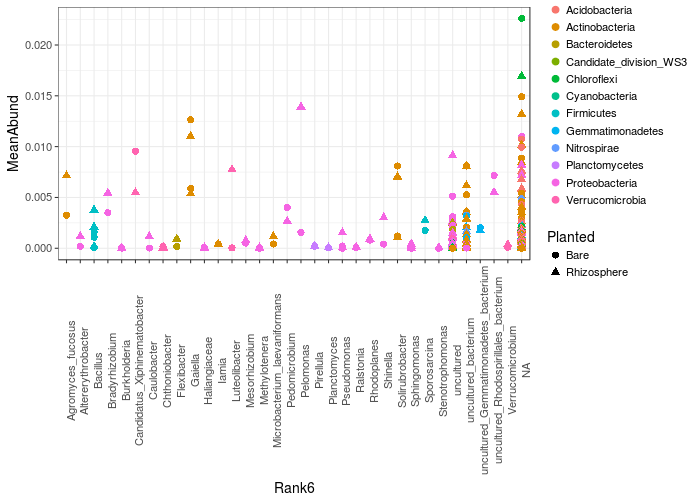

In [51]:
%%R -w 700 -h 500
ggplot(MeanFP, aes(x = Rank6, y = MeanAbund, shape = Planted, color = Rank2)) +
geom_point(size = 3)+
theme_bw(base_size = 14) +
theme(axis.text.x = element_text(angle = 90))

# Do negative controls display a biological pattern

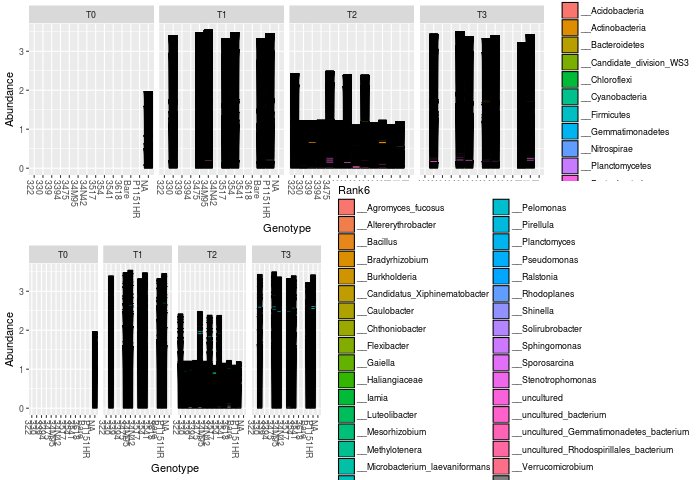

In [53]:
%%R -w 700
# false positive composition in controls

p1 = plot_bar(ERA.FP, fill = 'Rank2', x = "Genotype") +
    facet_wrap(~TimePoint, ncol = 5)

p2 = plot_bar(ERA.FP, fill = 'Rank6', x = "Genotype") +
    facet_wrap(~TimePoint, ncol = 5)

grid.arrange(p1, p2, ncol=1)

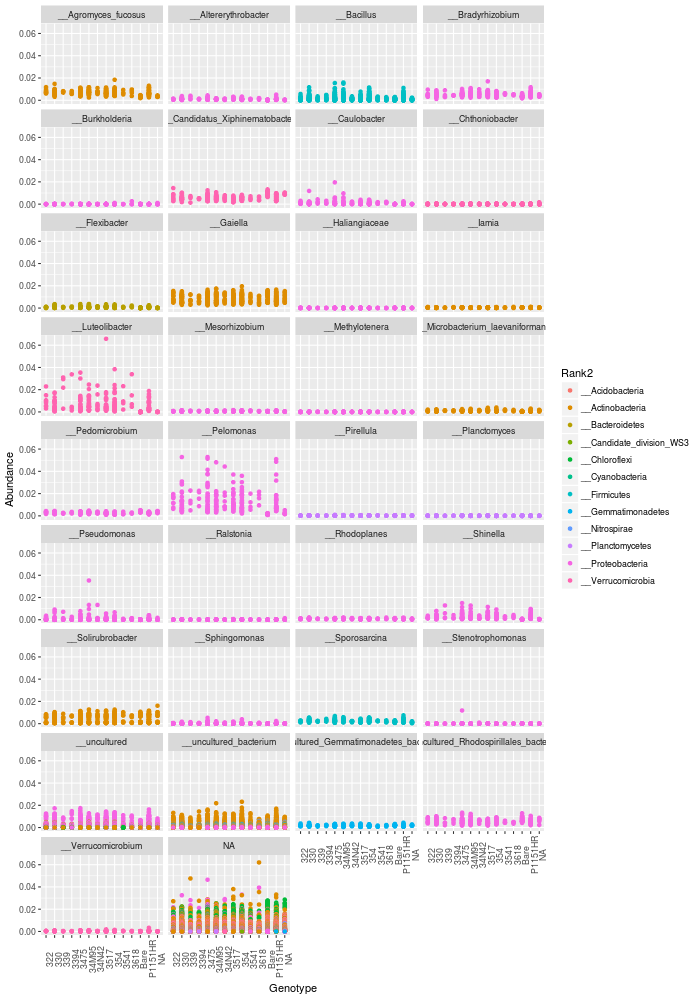

In [54]:
%%R -w 700 -h 1000
ggplot(mdf, aes(x = Genotype, y = Abundance, color = Rank2)) + 
    geom_point() + 
    facet_wrap(~Rank6, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90))

In [55]:
%%R
sample_sums(phy)

        MockComm     NegControl_A NegControl_Plate     PosControl_B 
           92710              150              264               29 
    NegControl_B     PosControl_A PostiveControl_C     NegControl_C 
            1271               74               26               38 
     IndexQC_Rev 
               1 


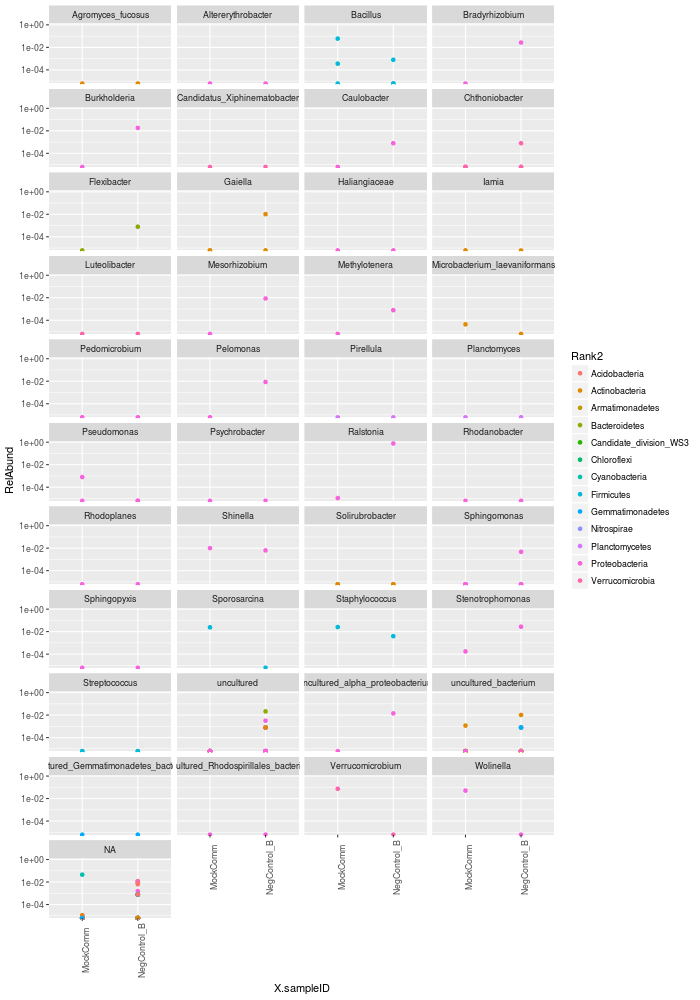

In [59]:
%%R -w 700 -h 1000

tmp = subset_samples(controls.FP, X.sampleID %in% c("MockComm", "NegControl_B"))
c.mdf=psmelt(tmp)

c.mdf = mutate(c.mdf, RelAbund = ifelse(X.sampleID == "MockComm", Abundance/92710, 
                                     Abundance/1271)) 


ggplot(c.mdf, aes(x = X.sampleID, y = RelAbund, color = Rank2)) + 
    geom_point() + 
    facet_wrap(~Rank6, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90)) +
    scale_y_log10()

* Negative controls show sequences
* There was no amplification of negative controls per gel visualization monitoring
* Of false positives, only pseudomonas shows up in appreciable ammounts in Mock community 
* Neg Control had only 686 reads, one tenth of the lowest sample count 
* Unlikely that contamination is contributing greatly to samples
* Genus designations are suspect